In [7]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from matplotlib.ticker import LogLocator, FormatStrFormatter
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

EPS = 1e-5  # define a small constant for numerical stability control

## importance sampling during training

Below is an example implementation of a PINN in PyTorch that incorporates self-adaptive importance sampling similar to the paper. In this simplified example, we solve a one-dimensional PDE (here, we use a toy example u_xx +sin(πx)=0) by training on collocation points that are periodically updated by sampling more densely in regions where the PDE residual is high.

You can adjust the PDE, network architecture, and hyperparameters as needed.

### Sampling Strategy:

Initially, collocation points are sampled uniformly.
In the function importance_sampling, the model is evaluated on a dense grid over the domain. The absolute value of the residual (plus a small epsilon) forms a weight distribution, and new collocation points are drawn according to this distribution. This mimics the failure-informed sampling by focusing training on regions where the PDE is not well satisfied.
### Training Loop:
The model trains for a set number of epochs. Every few epochs (here, every 1000 epochs), the collocation points are updated using the importance sampling procedure.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network for the PINN
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        # Create a fully connected network based on the provided layers list.
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()
    
    def forward(self, x):
        a = x
        for layer in self.layers[:-1]:
            a = self.activation(layer(a))
        output = self.layers[-1](a)
        return output

# Define the PDE residual
def pde_residual(model, x):
    # Enable gradient tracking on x
    x.requires_grad = True
    u = model(x)
    # Compute first derivative u_x
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    # Compute second derivative u_xx
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    # For this example, our PDE is: u_xx + sin(pi*x) = 0
    residual = u_xx + torch.sin(np.pi * x)
    return residual

# Generate initial collocation points uniformly in the domain [lb, ub]
def generate_collocation_points(n_points, lb, ub):
    x = np.random.uniform(lb, ub, (n_points, 1))
    return torch.tensor(x, dtype=torch.float32)

# Importance sampling: Evaluate the residual on a fine grid and sample new points
def importance_sampling(model, n_points, lb, ub):
    # Create a fine grid over the domain
    x_fine = np.linspace(lb, ub, 1000).reshape(-1, 1)
    x_fine_tensor = torch.tensor(x_fine, dtype=torch.float32)
    
    # Evaluate the residual on the fine grid
    residual = pde_residual(model, x_fine_tensor)
    res_val = residual.detach().abs().squeeze().numpy()  # absolute error
    # Avoid zero probabilities by adding a small epsilon
    eps = 1e-6
    weights = res_val + eps
    weights = weights / np.sum(weights)
    # Sample indices based on the residual weights
    indices = np.random.choice(len(x_fine), size=n_points, replace=True, p=weights)
    sampled_points = x_fine[indices]
    return torch.tensor(sampled_points, dtype=torch.float32)

# Hyperparameters and domain setup
lb, ub = 0.0, 1.0         # Domain boundaries
n_initial = 100           # Number of initial collocation points
n_epochs = 1000           # Total training epochs
sampling_interval = 200  # How often (in epochs) to update the collocation points
learning_rate = 1e-3      # Learning rate

# Define the network architecture (input, hidden layers, output)
layers = [1, 50, 50, 1]
model = PINN(layers)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
mse_loss = nn.MSELoss()

# Generate the initial set of collocation points
collocation_points = generate_collocation_points(n_initial, lb, ub)

# Training loop
for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Compute the residual of the PDE at the collocation points
    residual = pde_residual(model, collocation_points)
    loss_res = mse_loss(residual, torch.zeros_like(residual))
    
    # (Optional) Include boundary conditions loss here.
    # For example, enforcing u(0)=0 and u(1)=0:
    x_bc = torch.tensor([[lb], [ub]], dtype=torch.float32)
    u_bc = model(x_bc)
    loss_bc = mse_loss(u_bc, torch.zeros_like(u_bc))
    
    loss = loss_res + loss_bc
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.6f}")
    
    # Every sampling_interval epochs, perform importance sampling to update collocation points.
    if (epoch + 1) % sampling_interval == 0:
        collocation_points = importance_sampling(model, n_initial, lb, ub)
        print(f"Resampled collocation points at epoch {epoch+1}")

# After training, evaluate the model on a fine grid and plot the results.
x_fine = np.linspace(lb, ub, 1000).reshape(-1, 1)
x_fine_tensor = torch.tensor(x_fine, dtype=torch.float32)
model.eval()
with torch.no_grad():
    u_pred = model(x_fine_tensor).detach().cpu().numpy()

# Exact solution: u(x) = (1/pi^2)*sin(pi*x) with u(0)=u(1)=0.
u_exact = (1/np.pi**2) * np.sin(np.pi * x_fine)

plt.figure(figsize=(8, 5))
plt.plot(x_fine, u_pred, label='PINN Approximation', linewidth=2)
plt.plot(x_fine, u_exact, 'r--', label='Exact Solution', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('PINN Approximation vs Exact Solution')
plt.show()


In [ ]:
# Evaluate g(x) and residual for each sample
def evaluate_G_and_residual(PINN_model, samples, t_coll, params,lambda_bc=2.0):

    t0_tensor =torch.zeros_like(t_coll).requires_grad_(True)
    G_values = []
    residual_values = []

    for i in range(len(samples)):
        row = samples[i]
        input_params = make_input_params(t_coll, row, params['norm_info'])

        # Ensure tensors require gradients
        m_tensor = input_params[0].requires_grad_(True)
        mu_tensor = input_params[1].requires_grad_(True)
        k_tensor = input_params[2].requires_grad_(True)
        y0_tensor = input_params[3].requires_grad_(True)
        v0_tensor = input_params[4].requires_grad_(True)
        
        # Evaluate the limit state function G(x) for each sample
        G_values.append(limit_state_function_G(PINN_model, t_coll, input_params, differentiable=False).item())

        # Compute the residual
        pde_residual = pde_loss(PINN_model, t_coll.requires_grad_(True), m_tensor, mu_tensor, k_tensor, y0_tensor, v0_tensor, norm_info=params['norm_info']).item()
        # Compute the boundary loss
        boundary_residual = boundary_loss(PINN_model, t0_tensor, m_tensor, mu_tensor, k_tensor, y0_tensor, v0_tensor, norm_info=params['norm_info']).item()
        residual_values.append(pde_residual + lambda_bc * boundary_residual)

    # Convert to NumPy arrays for sampling
    # Not really needed, but for more versatile use it is better to have them in numpy format
    G_vals = np.array(G_values)
    residual_vals = np.array(residual_values)
    return G_vals, residual_vals

In [ ]:
plt.figure(figsize=(12, 6))
# Plot g_weights
plt.subplot(1, 2, 1)
plt.plot(G_weights[:20], 'o', label='g_weights', color='blue')
plt.title('g_weights')
plt.xlabel('Index')
plt.ylabel('Weight')
plt.grid(True)
plt.legend()

# Plot g_vals
plt.subplot(1, 2, 2)
plt.plot(-abs(G_vals[:20]), 'o-', label='g_vals', color='orange')
plt.title('g_vals')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# plotting exact and predicted solutions for a specific sample

N=2
t_coll = torch.linspace(0, 5, N).view(-1, 1) / specs['t']['range']
t_test = np.linspace(0, 5, N)
print(t_coll)

test_values = [1.2932, 0.4680, k_mean, y0_mean, v0_mean]
test_params = make_input_params(t_coll, test_values, params['norm_info'])

# Get the PINN prediction
y_pred = PINN_model(t_coll, *test_params)
print(y_pred)
# Compute the exact solution using the provided function (convert t_test to numpy)
y_exact = damped_harmonic_oscillator(t_test, 
                                        *test_values)

plt.plot(t_test, y_pred.detach().numpy(), color=colors[idx], label=f'm={m:.2f}')
plt.plot(t_test, y_exact, color=colors[idx], linestyle='--')
plt.xlim(4.9, 5)
plt.show()

In [ ]:
# def inspect_activations(model, x):
#     """
#     Feeds x through model.net and prints min/max pre-activations for each Linear layer.
#     x should be shape (1,6).
#     """
#     activ = x
#     layer_i = 0
#     for layer in model.net:
#         if isinstance(layer, nn.Linear):
#             z = layer(activ)
#             print(f"Layer {layer_i} pre-act:  min {z.min().item():.2f}, max {z.max().item():.2f}")
#             activ = z
#             layer_i += 1
#         else:  # nn.Tanh (or any activation)
#             activ = layer(activ)

# # Reconstruct each input as a (1,1) Tensor
# τ_test  = torch.tensor([[0.0]])  # normalized time = 0
# m_z_val = (4.0 - m_mean) / m_std
# mu_z_val = (mu_mean - mu_mean) / mu_std  # e.g. 0 at mean
# k_z_val  = 0.0
# y0_z_val = 0.0
# v0_z_val = (4.0 - v0_mean) / v0_std

# # Wrap each in a 1×1 Tensor
# m_z   = torch.tensor([[m_z_val]],   dtype=torch.float32)
# mu_z  = torch.tensor([[mu_z_val]],  dtype=torch.float32)
# k_z   = torch.tensor([[k_z_val]],   dtype=torch.float32)
# y0_z  = torch.tensor([[y0_z_val]],  dtype=torch.float32)
# v0_z  = torch.tensor([[v0_z_val]],  dtype=torch.float32)

# # Now concatenate along dim=1 to get shape (1,6)
# x_test = torch.cat([τ_test, m_z, mu_z, k_z, y0_z, v0_z], dim=1)

# # And inspect all layers’ pre‐activations:
# inspect_activations(PINN_model, x_test)

In [ ]:
import numpy as np

def sample_time_points(T, N, r):
    """
    Sample N time points from a truncated exponential distribution over [0, T].

    Parameters:
    - T: Total time duration.
    - N: Number of time points to sample.
    - r: Rate parameter of the exponential distribution.

    Returns:
    - Array of sampled time points.
    """
    if r == 0:
        # Uniform sampling
        return np.linspace(0, T, N)
    else:
        # Inverse transform sampling
        u = np.random.uniform(0, 1, N)
        return -np.log(1 - u * (1 - np.exp(-r * T))) / r

https://arxiv.org/abs/2404.18780

# XPINN

In [ ]:
# MLP backbone
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        layer_list = []
        for i in range(len(layers)-2):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            layer_list.append(nn.Tanh())
        layer_list.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*layer_list)

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        return self.model(X)
    
# XPINN container
class XPINN1D:
    def __init__(self, alpha, H_layers, layers, device):
        self.device = device
        # dimensionless PDE coefficients
        self.alpha1, self.alpha2, self.alpha3 = alpha
        self.H1, self.H2, self.H3 = H_layers
        # networks
        self.net1 = MLP(layers[0]).to(device)
        self.net2 = MLP(layers[1]).to(device)
        self.net3 = MLP(layers[2]).to(device)
        self.params = list(self.net1.parameters()) + list(self.net2.parameters()) + list(self.net3.parameters())
        self.optimizer = torch.optim.Adam(self.params, lr=1e-3)
        self.loss_fn = nn.MSELoss()

    # local evaluations
    def _u1(self, x, t): return self.net1(x, t)
    def _u2(self, x, t): return self.net2(x - self.H1, t)
    def _u3(self, x, t): return self.net3(x - (self.H1 + self.H2), t)


In [ ]:
def pde_loss_terzaghi(u_pred, t, z, k, mv, H, norm_info=None):
    # First, compute the derivatives of the model output using the (normalized) inputs.
    u_t_norm = torch.autograd.grad(u_pred, t, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]  # Time derivative
    u_z_norm = torch.autograd.grad(u_pred, z, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]  # First spatial derivative (w.r.t z)
    u_zz_norm = torch.autograd.grad(u_z_norm, z, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]  # Second spatial derivative (w.r.t z)

    # If norm_info is provided, denormalize the parameters for the PDE residual.
    if norm_info is not None:
        # Denormalize k, mv, and H using the norm_info dictionary (if present)
        k_phys = z_score_denormalize(k, norm_info['k']) if 'k' in norm_info else k.detach()
        mv_phys = z_score_denormalize(mv, norm_info['mv']) if 'mv' in norm_info else mv.detach()
        H_phys = z_score_denormalize(H, norm_info['H']) if 'H' in norm_info else H.detach()

        # Time scaling factor: Use the range of time for the normalization
        dt_dt_hat = norm_info['t']['range']  # Physical time range scaling factor (from 0 to t_f)
        u_t = u_t_norm / dt_dt_hat  # Scale the time derivative by the time range

        # Depth scaling factor: Use the height of the soil column for normalization
        dt_dz_hat = H_phys
        u_zz = u_zz_norm / (dt_dz_hat ** 2)  # Scale the second spatial derivative by H^2 for the depth normalization

    else:
        # If no normalization info is provided, use the normalized values directly
        u_t = u_t_norm
        u_zz = u_zz_norm

        # Use physical values directly for k, mv, and H
        k_phys = k
        mv_phys = mv
        H_phys = H

    yw = 9.81  # unit weight of water (kN/m³)
    
    # Compute the PDE residual using physical parameters (Terzaghi consolidation equation)
    residual = u_t - (k_phys / (mv_phys * yw)) * u_zz  # Consolidation PDE

    # Return the mean squared error of the residual as the loss function
    return torch.mean(residual**2)


In [74]:
def set_seed(seed=42):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # Numpy random module
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # All GPUs (if multiple)

# Set the seed
set_seed(123)

# Define the neural network for the Physics-Informed Neural Network (PINN)
class pinn(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3):
        super(pinn, self).__init__()
        layers = [nn.Linear(3, hidden_size), nn.Tanh()]  # Change Tanh to GeLU
        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())  # Change Tanh to GeLU
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

def pde_residual(model, coords):
    cv = 1e-2*10/(3e-4*9.81*(coords[:,2]*10)**2)  # Coefficient of consolidation (per ten years)
    u = model(coords)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = grads[:, 0]
    u_zz = torch.autograd.grad(grads[:, 1], coords, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    return torch.mean((u_t - cv * u_zz)**2)

def pde_residual_2(model, coords):
    cv = 5e-2*10/(3e-4*9.81*(coords[:,2]*10)**2)  # Coefficient of consolidation (per ten years)
    u = model(coords)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = grads[:, 0]
    u_zz = torch.autograd.grad(grads[:, 1], coords, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    return torch.mean((u_t - cv * u_zz)**2)

#Boundary conditions:
def loss_boundary_z0(model,boundary_points):
    u_pred = model(boundary_points)
    return torch.mean((u_pred)**2)

def loss_boundary_z1(model,boundary_points):
    u_pred = model(boundary_points)
    u_grad= torch.autograd.grad(u_pred,boundary_points,grad_outputs=torch.ones_like(u_pred),create_graph=True)[0] #This is the gradient of u 

    u_x = u_grad[:,1] # This is the z-component of the gradient of u
    return torch.mean((u_x)**2)

def loss_initial_condition(model, initial_points):
    u_pred = model(initial_points)
    return torch.mean((u_pred-1)**2)  # Assuming the initial condition is u(0, x) = 1 kPa (delta sigma = 1 kPa)

# Function to create boundary points
def create_boundary_points(num_points):
    t_coll_1 = torch.rand(num_points, 1)
    t_coll_2 = torch.rand(num_points, 1).requires_grad_(True)
    H_points_1 = torch.ones(num_points,1).requires_grad_(False)
    z0 = torch.zeros(num_points, 1)
    z1 = torch.ones(num_points, 1).requires_grad_(True)
    H_points_2 = torch.ones(num_points,1).requires_grad_(False)
    boundary_z0 = torch.cat([t_coll_1, z0,H_points_1], dim=1)
    boundary_z1 = torch.cat([t_coll_2, z1,H_points_2], dim=1)
    return boundary_z0, boundary_z1

def create_ic_points(num_points):
    t_coll = torch.zeros(num_points, 1)
    z_coll = torch.rand(num_points, 1)
    H_points = torch.ones(num_points,1).requires_grad_(False)
    initial_points = torch.cat([t_coll, z_coll, H_points], dim=1)
    return initial_points

def plot_losses(epochs, losses_dict):
    plt.figure(figsize=(8, 4))
    
    for loss_name, loss_values in losses_dict.items():
        plt.plot(epochs, loss_values, label=loss_name)
    plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.grid()
    plt.legend()
    plt.show()


def closure():
    # Compute individual loss terms
    loss_pde = pde_residual(model, train_points_1)
    loss_pde_2 = pde_residual_2(model, train_points_2)
    loss_z0 = loss_boundary_z0(model, boundary_points_z0)
    loss_z1 = loss_boundary_z1(model, boundary_points_z1)
    loss_ic = loss_initial_condition(model, initial_points)
    
    # Combine losses using the updated weights
    loss = (loss_weights[0] * loss_pde +
            loss_weights[4] * loss_pde_2 +
            loss_weights[1] * loss_z0 +
            loss_weights[2] * loss_z1 +
            loss_weights[3] * loss_ic)
    
    # Record losses and weights
    pde_losses.append(loss_pde.item())
    pde_losses_2.append(loss_pde_2.item())
    z0_losses.append(loss_z0.item())
    z1_losses.append(loss_z1.item())
    ic_losses.append(loss_ic.item())

    epochs_recorded.append(epoch)

    return loss

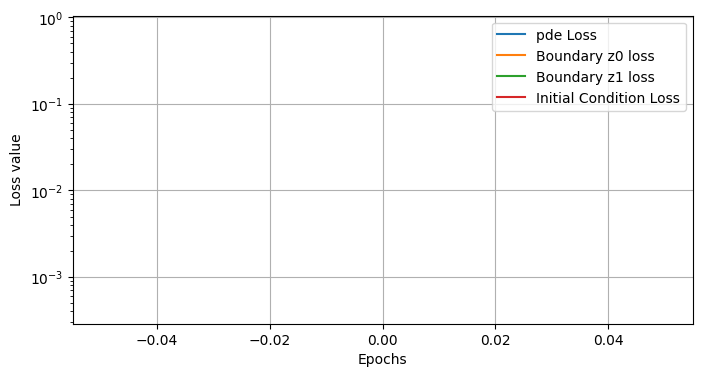

Epoch 0, Loss: 0.8674917221069336


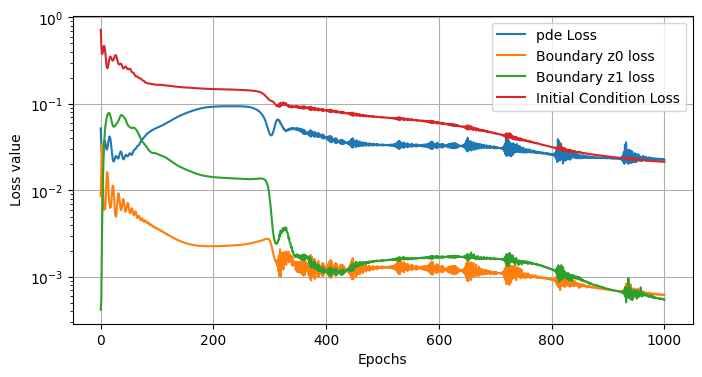

Epoch 1000, Loss: 0.06030455231666565


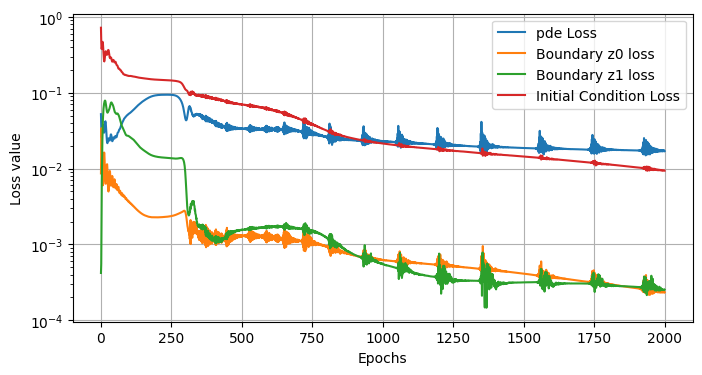

Epoch 2000, Loss: 0.03524355962872505


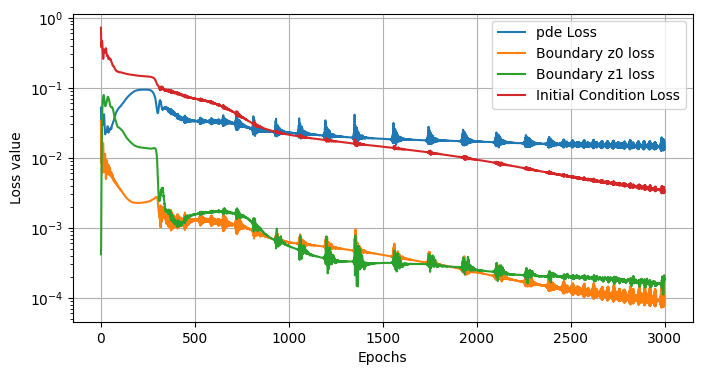

Epoch 3000, Loss: 0.02646973915398121


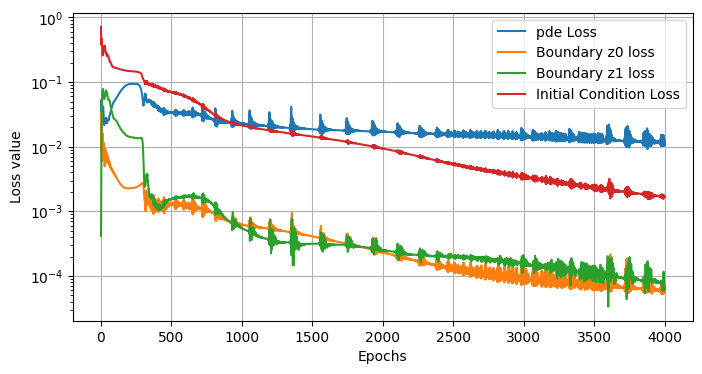

Epoch 4000, Loss: 0.02022351510822773


In [76]:
#_____________________________________________________________________________________________________________

#Domain size:
left, right, bottom, top = 0, 1, 0, 1

num_boundary_points = 100
boundary_points_z0 = create_boundary_points(num_boundary_points)[0]
boundary_points_z1 = create_boundary_points(num_boundary_points)[1]

initial_points = create_ic_points(num_boundary_points)

# Creating domain points
num_domain_points=1000
t_points = torch.rand(num_domain_points,1).requires_grad_(True)
z_points = torch.rand(num_domain_points,1).requires_grad_(True)*0.5
H_points = torch.ones(num_domain_points,1).requires_grad_(False) # H is constant in this case

t_points_2 = torch.rand(num_domain_points,1).requires_grad_(True)
z_points_2 = 1- torch.rand(num_domain_points,1).requires_grad_(True)*0.5
H_points_2 = torch.ones(num_domain_points,1).requires_grad_(False) # H is constant in this case

train_points_1=torch.cat([t_points,z_points,H_points],dim=1)
train_points_2=torch.cat([t_points_2,z_points_2,H_points_2],dim=1) 

# Initialize lists to store losses and plot
pde_losses = []
pde_losses_2 = []
z0_losses = []
z1_losses = []
ic_losses = []
epochs_recorded = []


#Defining hyperparameters:
model=pinn(hidden_size=30, hidden_layers=4) 

epochs=4001

# Initialize the loss weights
lambda_pde, lambda_z0, lambda_z1, lambda_ic = 1, 10, 1, 1


loss_weights = (torch.tensor([lambda_pde, lambda_z0, lambda_z1, lambda_ic, 1],
                            dtype=torch.float, requires_grad=False))

adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize the weights and biases of the model
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)  # Use Xavier initialization
        nn.init.zeros_(m.bias)  # Initialize biases to zero
# Apply weight initialization
model.apply(initialize_weights)


#Training loop:
for epoch in range(epochs):
    train_points_1   = train_points_1.detach().requires_grad_(True)
    train_points_2   = train_points_2.detach().requires_grad_(True)
    boundary_points_z0 = boundary_points_z0.detach().requires_grad_(True)
    boundary_points_z1 = boundary_points_z1.detach().requires_grad_(True)
    initial_points     = initial_points.detach().requires_grad_(True)
    adam_optimizer.zero_grad()
    loss=closure()
    loss.backward()
    adam_optimizer.step() # Update the weights and biases of the model

    # Logging
    if epoch % 1000 == 0:
        losses_dict = {
            "pde Loss": pde_losses,
            "Boundary z0 loss": z0_losses,
            "Boundary z1 loss": z1_losses,
            "Initial Condition Loss": ic_losses,
        }

        plot_losses(epochs_recorded, losses_dict)
        print(f"Epoch {epoch}, Loss: {loss.item()}")

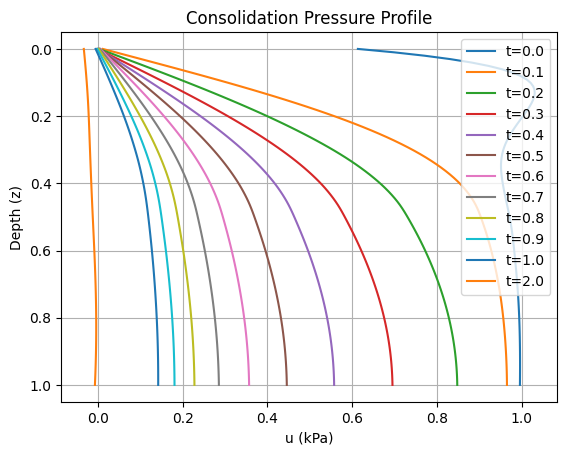

In [77]:
test_time_points = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2]
test_time_points = torch.tensor(test_time_points).view(-1, 1)
test_H_points = torch.ones(100, 1).requires_grad_(False)


test_depth_points = torch.linspace(0, 1, 100).view(-1, 1)
for t in test_time_points:
    # Create a grid of points for the current time
    grid_points = torch.cat((t.repeat(test_depth_points.size(0), 1), test_depth_points,test_H_points), dim=1)
    
    # Get the model predictions
    with torch.no_grad():
        u_pred = model(grid_points).numpy()
    
    # Plotting
    # Create a new figure

    plt.plot(u_pred,test_depth_points.numpy(), label=f't={t.item():.1f}')
plt.gca().invert_yaxis()
plt.ylabel('Depth (z)')
plt.xlabel('u (kPa)')
plt.title('Consolidation Pressure Profile')
plt.legend()
plt.grid()
plt.show()

Epoch 0, loss=2.005e+00
Epoch 1000, loss=4.584e-02
Epoch 2000, loss=2.336e-02
Epoch 3000, loss=1.840e-02
Epoch 4000, loss=1.524e-02


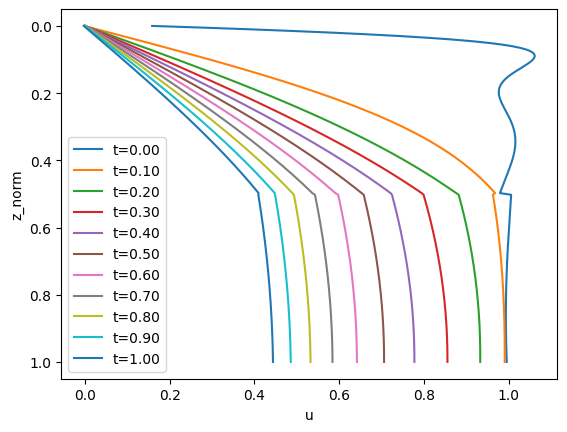

In [81]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

# reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(123)

# PINN architecture
def build_pinn(hidden_size=30, hidden_layers=4):
    layers = [nn.Linear(3, hidden_size), nn.GELU()]
    for _ in range(hidden_layers):
        layers.append(nn.Linear(hidden_size, hidden_size))
        layers.append(nn.GELU())
    layers.append(nn.Linear(hidden_size, 1))
    net = nn.Sequential(*layers)
    # Xavier initialization
    for m in net:
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)
    return net

# two sub-PINNs for each layer
model1 = build_pinn()
model2 = build_pinn()
optimizer = optim.Adam(list(model1.parameters()) + list(model2.parameters()), lr=1e-3)

# PDE residuals for each layer
def pde_residual(model, coords, factor):
    # coords: [t, z_norm, H_dummy]
    # factor = c_v / H^2 collapsed into one scalar or tensor
    u = model(coords)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t  = grads[:,0]
    u_z  = grads[:,1]
    u_zz = torch.autograd.grad(u_z, coords, grad_outputs=torch.ones_like(u_z), create_graph=True)[0][:,1]
    return torch.mean((u_t - factor * u_zz)**2)

# boundary & initial losses

def loss_b0(model, pts): return torch.mean(model(pts)**2)

def loss_b1(model, pts):
    u = model(pts)
    grads = torch.autograd.grad(u, pts, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return torch.mean(grads[:,1]**2)

def loss_ic(model, pts): return torch.mean((model(pts)-1)**2)

def loss_interface(m1, m2, pts, f1, f2):
    u1 = m1(pts); u2 = m2(pts)
    # continuity
    lp = torch.mean((u1-u2)**2)
    g1 = torch.autograd.grad(u1, pts, grad_outputs=torch.ones_like(u1), create_graph=True)[0][:,1]
    g2 = torch.autograd.grad(u2, pts, grad_outputs=torch.ones_like(u2), create_graph=True)[0][:,1]
    lf = torch.mean((f1*g1 - f2*g2)**2)
    return lp, lf

# generate training points
Nf, Nb, Ni, Ni_int = 1000, 100, 100, 100
# layer1: z_norm in [0,0.5]
t1 = torch.rand(Nf,1).requires_grad_(True)
z1 = (torch.rand(Nf,1)*0.5).requires_grad_(True)
factor1 = (1e-2 * 10/(3e-4*9.81)) / (10**2)  # precomputed c_v/H^2 for layer1
train1 = torch.cat([t1, z1, torch.ones_like(z1)], dim=1)
# layer2: z_norm in (0.5,1]
t2 = torch.rand(Nf,1).requires_grad_(True)
z2 = (0.5 + torch.rand(Nf,1)*0.5).requires_grad_(True)
factor2 = (5e-2 * 10/(3e-4*9.81)) / (10**2)
train2 = torch.cat([t2, z2, torch.ones_like(z2)], dim=1)
# boundaries and initial
t_b0 = torch.rand(Nb,1).requires_grad_(True); b0 = torch.cat([t_b0, torch.zeros_like(t_b0), torch.ones_like(t_b0)],1)
t_b1 = torch.rand(Nb,1).requires_grad_(True); b1 = torch.cat([t_b1, torch.ones_like(t_b1), torch.ones_like(t_b1)],1)
t_i1 = torch.zeros(Ni,1).requires_grad_(True); ic1 = torch.cat([t_i1, torch.rand(Ni,1)*0.5, torch.ones_like(t_i1)],1)
t_i2 = torch.zeros(Ni,1).requires_grad_(True); ic2 = torch.cat([t_i2, 0.5+torch.rand(Ni,1)*0.5, torch.ones_like(t_i2)],1)
# interface at z_norm=0.5
t_int = torch.rand(Ni_int,1).requires_grad_(True)
int_pts = torch.cat([t_int, 0.5*torch.ones_like(t_int), torch.ones_like(t_int)],1)

# loss weights
w = {'pde1':1,'pde2':1,'b0':10,'b1':1,'ic':1,'lp':10,'lf':10}

# trainin 
for epoch in range(4001):
    optimizer.zero_grad()
    L1 = pde_residual(model1, train1, factor1)
    L2 = pde_residual(model2, train2, factor2)
    B0 = loss_b0(model1, b0)
    B1 = loss_b1(model2, b1)
    I1 = loss_ic(model1, ic1)
    I2 = loss_ic(model2, ic2)
    LP, LF = loss_interface(model1, model2, int_pts, factor1, factor2)
    loss = (w['pde1']*L1 + w['pde2']*L2 + w['b0']*B0 + w['b1']*B1
            + w['ic']*(I1+I2) + w['lp']*LP + w['lf']*LF)
    loss.backward()
    optimizer.step()
    if epoch%1000==0:
        print(f"Epoch {epoch}, loss={loss.item():.3e}")

# testing and plotting
test_times = torch.tensor([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]).view(-1,1)
depths    = torch.linspace(0,1,200).view(-1,1)
for t in test_times:
    u_vals = []
    for z in depths:
        coord = torch.tensor([[t.item(), z.item(), 1.0]])
        with torch.no_grad():
            if z<=0.5:
                u_vals.append(model1(coord).item())
            else:
                u_vals.append(model2(coord).item())
    plt.plot(u_vals, depths.numpy(), label=f"t={t.item():.2f}")
plt.gca().invert_yaxis(); plt.xlabel('u'); plt.ylabel('z_norm'); plt.legend(); plt.show()


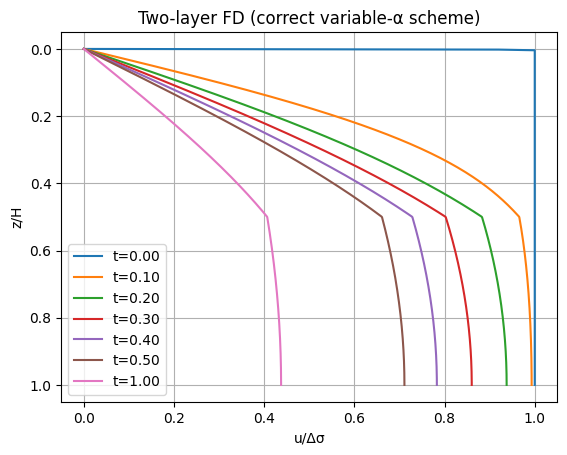

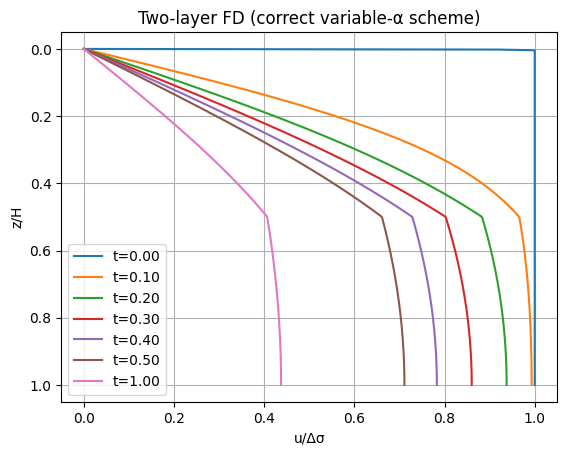

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Problem parameters
k1_phys, k2_phys = 2.74e-5, 1.37e-4
mv, yw = 3e-4, 9.81
H_phys, T_phys = 10.0, 10*365.0

cv1 = k1_phys/(mv*yw)
cv2 = k2_phys/(mv*yw)
alpha1 = cv1*T_phys/H_phys**2
alpha2 = cv2*T_phys/H_phys**2

# 2) Spatial grid
Nz = 500
z_nd = np.linspace(0,1,Nz)
dz   = z_nd[1]-z_nd[0]
# piecewise alpha
alpha = np.where(z_nd<=0.5, alpha1, alpha2)

# 3) Precompute interface values
# harmonic average at half‐grid
alpha_half = np.zeros(Nz-1)
alpha_half[:] = 2*alpha[:-1]*alpha[1:] / (alpha[:-1]+alpha[1:])

# 4) Time‐step size from CFL
dt = 0.4 * dz**2 / alpha.max()
Nt = int(np.ceil(1.0/dt)) + 1

# record times
record_t = [0.0,0.1,0.2,0.3,0.4,0.5,1.0]
record_steps = {int(t/dt):t for t in record_t}

# 5) initialize
u = np.ones(Nz)
u[0] = 0.0
u[-1] = u[-2]

u_hist = {}

# 6) time‐march
for n in range(Nt):
    u_new = u.copy()
    # compute fluxes F[i+1/2]
    F = alpha_half * (u[1:] - u[:-1]) / dz

    # update interior using flux difference
    u_new[1:-1] = u[1:-1] + (dt/dz)*(F[1:] - F[:-1])

    # BCs
    u_new[0]  = 0.0
    u_new[-1] = u_new[-2]

    u = u_new

    if n in record_steps:
        u_hist[record_steps[n]] = u.copy()

# 7) plot
# plt.figure(figsize=(5,7))
for t in record_t:
    plt.plot(u_hist[t], z_nd, label=f"t={t:.2f}")
plt.gca().invert_yaxis()
plt.xlabel("u/Δσ")
plt.ylabel("z/H")
plt.title("Two-layer FD (correct variable-α scheme)")
plt.legend()
plt.grid(True)
plt.show()


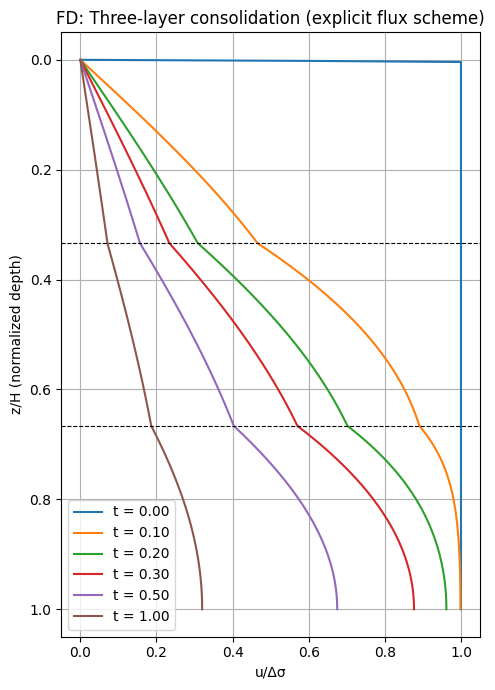

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# === 1) Physical parameters and nondimensional collapse factor α = cv·T_phys/H_phys² ===
k1_phys = 2.74e-5        # permeability in layer 1 [m/day]
k2_phys = 1.37e-5        # permeability in layer 2 [m/day]
k3_phys = 0.50e-5        # permeability in layer 3 [m/day]
mv      = 1e-4           # compressibility [m²/kN]
yw      = 9.81           # unit weight [kN/m³]
H_phys  = 10.0           # total thickness [m]
T_phys  = 10 * 365.0     # consolidation time span [days]

cv1 = k1_phys / (mv * yw)
cv2 = k2_phys / (mv * yw)
cv3 = k3_phys / (mv * yw)
alpha1 = cv1 * T_phys / H_phys**2
alpha2 = cv2 * T_phys / H_phys**2
alpha3 = cv3 * T_phys / H_phys**2

# === 2) Spatial grid (normalized z ∈ [0,1]) ===
Nz   = 500
z_nd = np.linspace(0, 1, Nz)
dz   = z_nd[1] - z_nd[0]

# define layer boundaries at 1/3 and 2/3
z1, z2 = 1/3, 2/3
alpha = np.zeros(Nz)
alpha[z_nd <= z1]        = alpha1
alpha[(z_nd > z1) & (z_nd <= z2)] = alpha2
alpha[z_nd > z2]         = alpha3

# === 3) Precompute interface values (harmonic average) ===
alpha_half = np.zeros(Nz - 1)
alpha_half[:] = 2 * alpha[:-1] * alpha[1:] / (alpha[:-1] + alpha[1:])

# === 4) Time stepping parameters (explicit scheme stability) ===
dt = 0.4 * dz**2 / alpha.max()   # CFL-limited time step
Nt = int(np.ceil(1.0 / dt)) + 1  # nondimensional end time T_nd = 1.0

# times at which to record solution
record_times = [0.0, 0.1, 0.2, 0.3, 0.5, 1.0]
record_steps = {int(t / dt): t for t in record_times}

# === 5) Initialize u (u/Δσ), BC: u(0)=0, ∂u/∂z(1)=0 ===
u = np.ones(Nz)                 # initial u = 1 everywhere
u[0] = 0.0                      # drained top: u=0
u[-1] = u[-2]                   # impermeable bottom: du/dz=0

# storage
u_history = {}

# === 6) Time march using flux form ===
for n in range(Nt):
    u_new = u.copy()
    
    # compute fluxes F[i+1/2] = alpha_{i+1/2} * (u[i+1] - u[i]) / dz
    F = alpha_half * (u[1:] - u[:-1]) / dz

    # update interior points via flux divergence
    u_new[1:-1] = u[1:-1] + (dt / dz) * (F[1:] - F[:-1])

    # reapply BCs
    u_new[0]  = 0.0
    u_new[-1] = u_new[-2]

    u = u_new

    # record if on our list
    if n in record_steps:
        u_history[record_steps[n]] = u.copy()

# === 7) Plot results ===
plt.figure(figsize=(5,7))
for t in record_times:
    plt.plot(u_history[t], z_nd, label=f't = {t:.2f}')
# mark layer interfaces
plt.axhline(z1, color='k', linestyle='--', linewidth=0.8)
plt.axhline(z2, color='k', linestyle='--', linewidth=0.8)
plt.gca().invert_yaxis()
plt.xlabel('u/Δσ')
plt.ylabel('z/H (normalized depth)')
plt.title('FD: Three-layer consolidation (explicit flux scheme)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

# reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(123)

# simple MLP builder
def build_pinn(hidden_size=30, hidden_layers=4):
    layers = [nn.Linear(3, hidden_size), nn.GELU()]
    for _ in range(hidden_layers):
        layers += [nn.Linear(hidden_size, hidden_size), nn.GELU()]
    layers.append(nn.Linear(hidden_size, 1))
    net = nn.Sequential(*layers)
    # Xavier init
    for m in net:
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)
    return net

# instantiate three sub-PINNs
model1 = build_pinn()
model2 = build_pinn()
model3 = build_pinn()

optimizer = optim.Adam(
    list(model1.parameters()) +
    list(model2.parameters()) +
    list(model3.parameters()),
    lr=1e-3
)

# PDE residual for a given layer
def pde_residual(model, coords, factor):
    u     = model(coords)
    grads = torch.autograd.grad(u, coords,
            grad_outputs=torch.ones_like(u),
            create_graph=True)[0]
    u_t   = grads[:,0]
    u_z   = grads[:,1]
    u_zz  = torch.autograd.grad(u_z, coords,
            grad_outputs=torch.ones_like(u_z),
            create_graph=True)[0][:,1]
    return torch.mean((u_t - factor * u_zz)**2)

# boundary losses
def loss_b0(m):
    # u(z=0)=0
    return torch.mean(m(b0_pts)**2)

def loss_b1(m):
    # ∂u/∂z(z=1)=0
    u = m(b1_pts)
    grads = torch.autograd.grad(u, b1_pts,
            grad_outputs=torch.ones_like(u),
            create_graph=True)[0]
    return torch.mean(grads[:,1]**2)

# initial‐condition loss u(z,0)=1
def loss_ic(m, pts):
    return torch.mean((m(pts) - 1.0)**2)

# interface loss between two models
def loss_interface(mA, mB, pts, fA, fB):
    uA = mA(pts)
    uB = mB(pts)
    # continuity of pressure
    lp = torch.mean((uA - uB)**2)
    # continuity of flux: fA ∂uA/∂z = fB ∂uB/∂z
    gA = torch.autograd.grad(uA, pts,
             grad_outputs=torch.ones_like(uA),
             create_graph=True)[0][:,1]
    gB = torch.autograd.grad(uB, pts,
             grad_outputs=torch.ones_like(uB),
             create_graph=True)[0][:,1]
    lf = torch.mean((fA*gA - fB*gB)**2)
    return lp, lf

# --- generate collocation & IC/BC points ---
Nf, Nb, Ni, Ni_int = 1000, 100, 100, 100

# layer-1 (0 ≤ z ≤ 1/3)
t1 = torch.rand(Nf,1).requires_grad_(True)
z1 = (torch.rand(Nf,1) * (1/3)).requires_grad_(True)
train1 = torch.cat([t1, z1, torch.ones_like(z1)], dim=1)
# consolidation factors precomputed
factor1 = 1.0  # your nondimensional cv/H^2 for layer1

# layer-2 (1/3 < z ≤ 2/3)
t2 = torch.rand(Nf,1).requires_grad_(True)
z2 = (1/3 + torch.rand(Nf,1)*(1/3)).requires_grad_(True)
train2 = torch.cat([t2, z2, torch.ones_like(z2)], dim=1)
factor2 = 0.5  # your cv/H^2 for layer2

# layer-3 (2/3 < z ≤ 1)
t3 = torch.rand(Nf,1).requires_grad_(True)
z3 = (2/3 + torch.rand(Nf,1)*(1/3)).requires_grad_(True)
train3 = torch.cat([t3, z3, torch.ones_like(z3)], dim=1)
factor3 = 0.2  # your cv/H^2 for layer3

# BC: z=0   drained
t_b0 = torch.rand(Nb,1).requires_grad_(True)
b0_pts = torch.cat([t_b0, torch.zeros_like(t_b0), torch.ones_like(t_b0)], dim=1)
# BC: z=1   no‐flow
t_b1 = torch.rand(Nb,1).requires_grad_(True)
b1_pts = torch.cat([t_b1, torch.ones_like(t_b1), torch.ones_like(t_b1)], dim=1)

# IC: t=0 in each layer
z_i1 = torch.rand(Ni,1)*(1/3)
ic1 = torch.cat([torch.zeros(Ni,1), z_i1, torch.ones_like(z_i1)], dim=1)
z_i2 = 1/3 + torch.rand(Ni,1)*(1/3)
ic2 = torch.cat([torch.zeros(Ni,1), z_i2, torch.ones_like(z_i2)], dim=1)
z_i3 = 2/3 + torch.rand(Ni,1)*(1/3)
ic3 = torch.cat([torch.zeros(Ni,1), z_i3, torch.ones_like(z_i3)], dim=1)

# interface points at z=1/3 and z=2/3
t_int1 = torch.rand(Ni_int,1).requires_grad_(True)
int1  = torch.cat([t_int1, (1/3)*torch.ones_like(t_int1), torch.ones_like(t_int1)], dim=1)
t_int2 = torch.rand(Ni_int,1).requires_grad_(True)
int2  = torch.cat([t_int2, (2/3)*torch.ones_like(t_int2), torch.ones_like(t_int2)], dim=1)

# weights
w = {
  'pde1':1, 'pde2':1, 'pde3':1,
  'b0':10, 'b1':1,
  'ic':1,
  'lp1':10, 'lf1':10,
  'lp2':10, 'lf2':10
}

# --- training loop ---
for epoch in range(4001):
    optimizer.zero_grad()
    Lp1 = pde_residual(model1, train1, factor1)
    Lp2 = pde_residual(model2, train2, factor2)
    Lp3 = pde_residual(model3, train3, factor3)
    B0  = loss_b0(model1)
    B1  = loss_b1(model3)
    I1  = loss_ic(model1, ic1)
    I2  = loss_ic(model2, ic2)
    I3  = loss_ic(model3, ic3)
    LP1, LF1 = loss_interface(model1, model2, int1, factor1, factor2)
    LP2, LF2 = loss_interface(model2, model3, int2, factor2, factor3)

    loss = (
       w['pde1']*Lp1 + w['pde2']*Lp2 + w['pde3']*Lp3
     + w['b0']*B0    + w['b1']*B1
     + w['ic']*(I1+I2+I3)
     + w['lp1']*LP1  + w['lf1']*LF1
     + w['lp2']*LP2  + w['lf2']*LF2
    )
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, loss={loss.item():.3e}")




Epoch 0, loss=3.039e+00
Epoch 500, loss=1.641e-01
Epoch 1000, loss=1.065e-01
Epoch 1500, loss=6.609e-02
Epoch 2000, loss=3.798e-02
Epoch 2500, loss=2.714e-02
Epoch 3000, loss=1.908e-02
Epoch 3500, loss=1.552e-02
Epoch 4000, loss=1.349e-02


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

<Figure size 500x700 with 0 Axes>

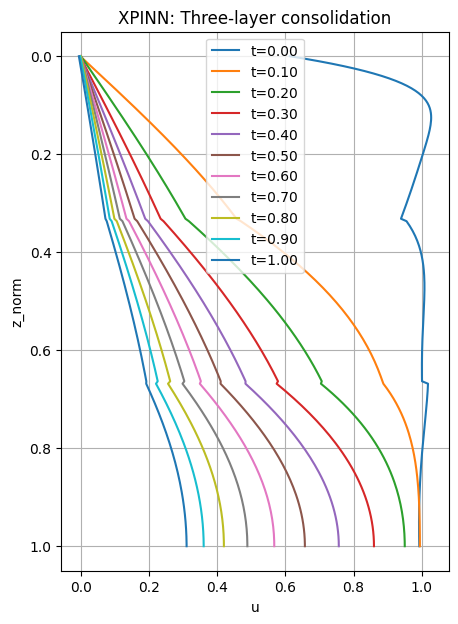

In [112]:
# --- testing & plotting ---
test_t = torch.linspace(0,1,11).view(-1,1)
z_plot = torch.linspace(0,1,200).view(-1,1)

plt.figure(figsize=(5,7))
for t in test_t:
    u_vals = []
    for z in z_plot:
        inp = torch.cat([t.view(-1, 1), z.view(-1, 1), torch.ones_like(t).view(-1, 1)], dim=1)
        with torch.no_grad():
            if z.item() <= 1/3:
                u_vals.append(model1(inp).item())
            elif z.item() <= 2/3:
                u_vals.append(model2(inp).item())
            else:
                u_vals.append(model3(inp).item())
    plt.plot(u_vals, z_plot.numpy(), label=f"t={t.item():.2f}")

plt.gca().invert_yaxis()
plt.xlabel("u")
plt.ylabel("z_norm")
plt.title("XPINN: Three-layer consolidation")
plt.legend()
plt.grid(True)
plt.show()